<h1> DS200A Computer Vision Assignment</h1>

<h2>  Part Two: Exploratory data analysis and feature extraction. </h2>	


<h5> In this section, Compute at least 15 such image features (a method for each), including the following (NOTE: At least 10 of these must be scalar features and 2 matrix-based features): (i) image size, (ii) average of the red-channel intensity, (iii) aspectratio. This will require significant explatoratory research and data analysis. The first one is already implemented for you, and the next two are pre-specified. Additional requirements specfied in pdf. </h5>

In [1]:
import skimage
from skimage import io
from matplotlib import pyplot as plt
import cv2
import seaborn as sns
from skimage import feature
from skimage.transform import resize
from skimage.feature import hog
import pandas as pd
import numpy as np
import pickle
from sklearn.cluster import MiniBatchKMeans

/Users/Jerome/anaconda/lib/python3.6/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


In [2]:
# Scalar feature
def ft0(image):
    # Returns the pixel size of the image
    return image.size

# Scalar feature
def ft1(image):
    # Returns the average of the red-channel pictures for the images
    return np.mean(image[:, :, 0])

# Scalar feature
def ft2(image):
    # Returns the aspect ratio of the image
    height, width = image.shape[:2]
    return width / height

# Scalar feature
def ft3(image):
    # Returns the average of the blue-channel pictures for the images
    return np.mean(image[:, :, 2])

# Scalar feature
def ft4(image):
    # Returns the average of the green-channel pictures for the images
    return np.mean(image[:, :, 1])

# Scalar feature
def ft5(image):
    # Return average hue
    temp = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    return np.mean(temp[:, :, 0])

# Scalar feature
def ft6(image):
    # Return average saturation
    temp = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    return np.mean(temp[:, :, 1])

# Scalar feature
def ft7(image):
    # Return average "brightness" value (in HSV)
    temp = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    return np.mean(temp[:, :, 2])

# Matrix feature
def ft_sift(data, kmeans):
    all_hist = np.vstack(data["Pictures"].apply(lambda img: build_histogram(get_sift_des(img), kmeans)))
    feature_df = pd.DataFrame(all_hist)
    return feature_df

# Matrix feature
def ft_hog(data):
    hog_ls = np.vstack([get_hog(img) for img in data["Pictures"]])
    hog_mat = np.vstack(hog_ls)
    feature_df = pd.DataFrame(hog_mat)
    return feature_df

# Matrix feature
def ft_orb(data, kmeans_orb):
    all_hist = np.vstack(data["Pictures"].apply(lambda img: build_histogram(get_orb_des(img), kmeans_orb)))
    orb_feature_df = pd.DataFrame(all_hist)
    return orb_feature_df

# Matrix feature
def ft_surf(data, kmeans_surf):
    all_hist = np.vstack(data["Pictures"].apply(lambda img: build_histogram(get_surf_des(img), kmeans_surf)))
    surf_feature_df = pd.DataFrame(all_hist)
    return surf_feature_df

 We expect all external sources sited, and significant indication of EDA. 

In this part, we focus on the learning set. Let's load the data first.

In [3]:
labels = pd.read_csv("labels.csv", index_col=0)
learning = pd.read_pickle("train.pkl")
print(learning.shape)
learning.head()

(1501, 2)


,Pictures,Encodings
0,"[[[255, 255, 255], [255, 255, 255], [255, 255,...",0
1,"[[[88, 56, 17], [95, 63, 24], [101, 69, 30], [...",0
2,"[[[255, 255, 255], [255, 255, 255], [255, 255,...",0
3,"[[[255, 255, 255], [255, 255, 255], [255, 255,...",0
4,"[[[255, 255, 255], [255, 255, 255], [255, 255,...",0


There are some images that are not in RGB. Let's convert them all to RGB for easy processing.

In [4]:
def gray_to_rgb(img):
    return cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)

def all_imgs_to_rgb(data):
    df = data.copy()
    is_gray = df["Pictures"].apply(lambda img: img.ndim != 3)
    rgb_imgs = df.loc[is_gray, "Pictures"].apply(gray_to_rgb)
    df.loc[is_gray, "Pictures"] = rgb_imgs
    print("Number of gray images: " + str(sum(df["Pictures"].apply(lambda img: img.ndim != 3))))
    return df

learning = all_imgs_to_rgb(learning)

Number of gray images: 0


Next, let's try to display 3 of the learning set images.

Label = penguin
Label = gorilla
Label = dolphin


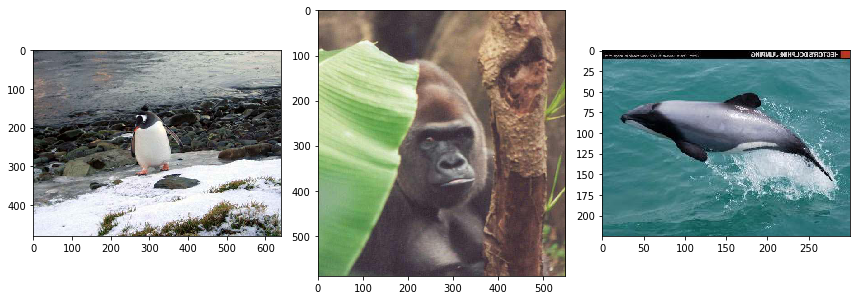

In [5]:
sample = learning.sample(3, random_state=42)
fig=plt.figure(figsize=(12, 7))
for i in range(len(sample)):
    row = sample.iloc[i]
    fig.add_subplot(1, 3, i + 1)
    skimage.io.imshow(row["Pictures"])
    print('Label = ' + labels.iloc[row["Encodings"]].labels)
plt.show()

Alright, everything seems working. We have an image of a penguin, a gorilla, and a dolphin.

Let's visualize the distribution of the classes to examine how imbalanced this dataset is.

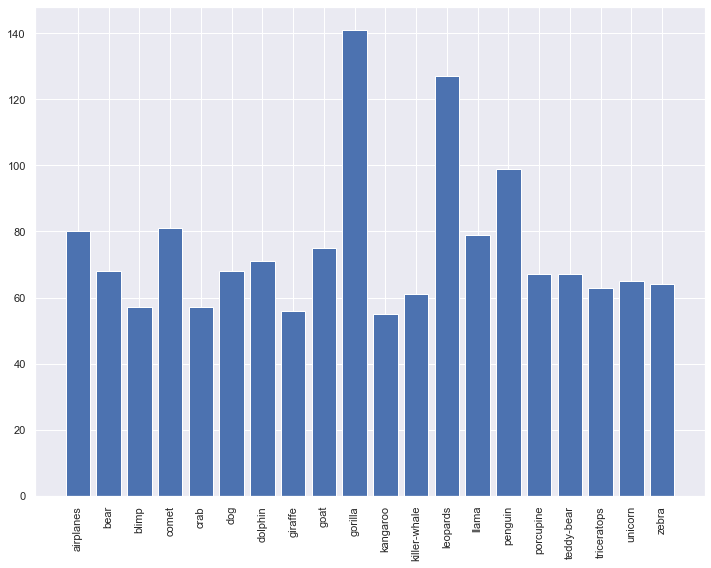

In [6]:
sns.set()
train = learning.copy()
train["name"] = train["Encodings"].apply(lambda x: labels["labels"][x])
plt.figure(figsize=(12, 9))
class_dist = train.groupby("name").size()
plt.bar(x=class_dist.index, height=class_dist.values)
plt.xticks(rotation=90);

The good news is that the dataset is not too imbalanced. Most classes have a frequency of 60 - 80. However, there are exceptions. For instance, there're as much as 140 gorilla pictures, 120+ leopard pictures, and almost 100 penguin pictures.

<h4> Graphs </h4>

First, let's investigate the size of the images across different classes.

In [7]:
train_cpy = learning.copy()

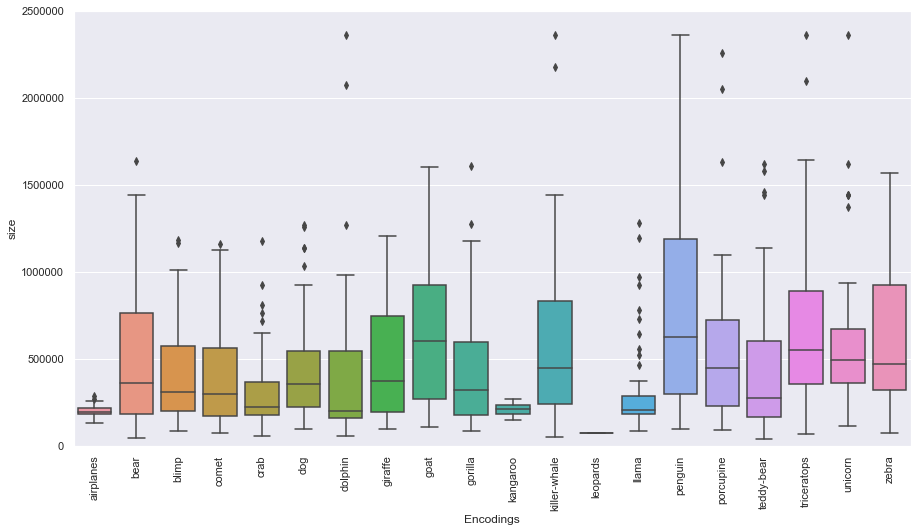

In [8]:
train_cpy["size"] = learning["Pictures"].apply(ft0)

plt.figure(figsize=(15,8))
ax = sns.boxplot(x="Encodings", y="size", data=train_cpy)
ax.set(ylim=(0, 2.5e6))
ax.set_xticklabels(labels['labels'], rotation=90);

Ignoring the outliers, we notice that almost all leopards have a small image size. The same goes for airplanes, kangaroo, and llama. By contrast, penguin has much variance in image sizes with a rather high the median value. In general, we observe a great variety of image size distributions for different classes, so it might be a feature that can help us differentiate between classes. However, we don't observe a particular, explainable pattern here.

Second, let's examine the average red-channel intensity.

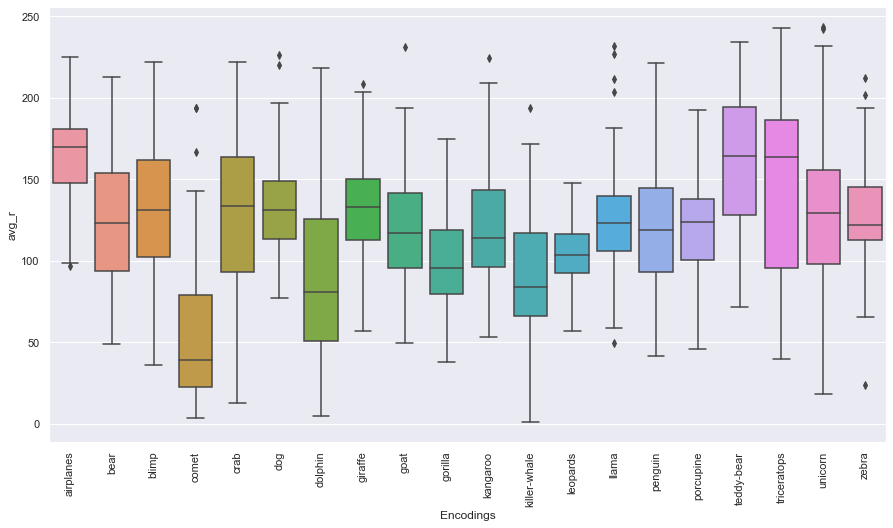

In [9]:
train_cpy["avg_r"] = learning["Pictures"].apply(ft1)
train_cpy.head()

plt.figure(figsize=(15,8))
ax = sns.boxplot(x="Encodings", y="avg_r", data=train_cpy)
ax.set_xticklabels(labels['labels'], rotation=90);

Interestingly, commet images exhibit low average red intensity. This should not be a big surprise because commet pictures we see are usually in a black background. Teddy bear and triceratops have high red intensity, probably due to their brown color. However, it is very interesting that airplanes have high red intensity. Let's look at some airplane pictures to understand why.

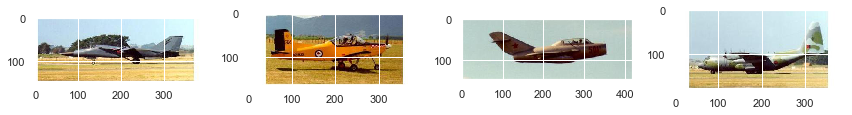

In [10]:
def show_sample_images(name):
    airplane_sample = learning[learning["Encodings"] == list(labels["labels"]).index(name)].sample(4, random_state=42)
    fig=plt.figure(figsize=(12, 7))
    for i in range(len(airplane_sample)):
        row = airplane_sample.iloc[i]
        fig.add_subplot(1, len(airplane_sample), i + 1)
        skimage.io.imshow(row["Pictures"])
    plt.show()


show_sample_images("airplanes")

We see that many airplane pictures have the bright sky as background. This may be the reason why airplane pictures have high red intensity because its background is almost as bright as white. Anyways, red intensity may also be a helpful feature for identifying classes like commets and airplanes.

Third, let's examine the aspect ratio feature.

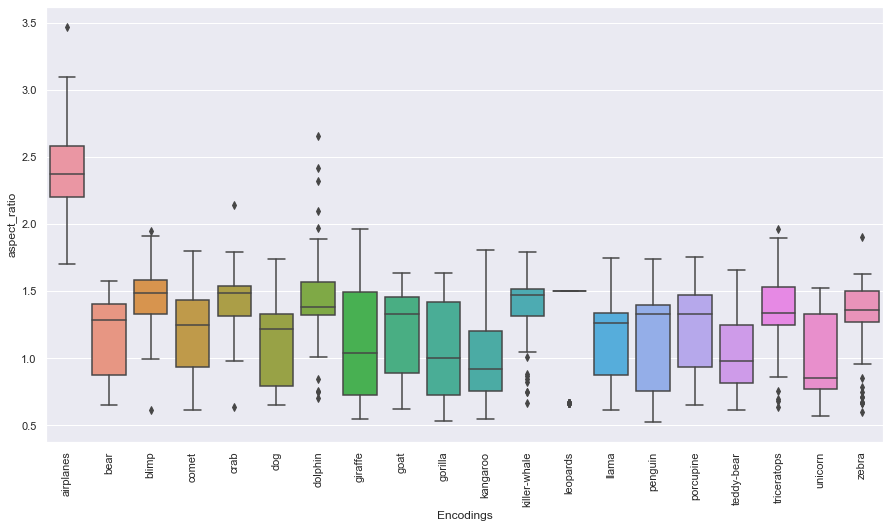

In [11]:
train_cpy["aspect_ratio"] = learning["Pictures"].apply(ft2)
train_cpy.head()

plt.figure(figsize=(15,8))
ax = sns.boxplot(x="Encodings", y="aspect_ratio", data=train_cpy)
ax.set_xticklabels(labels['labels'], rotation=90);

Airplane images have a very high aspect ratio. Judging from our sample images, most airplane pictures are flat, because that fits with the position in which the airplane flys. Sensibly, airplanes seldome fly vertically. Therefore, aspect ratio is a good feature for identifying airplanes.

Interestingly, almost all leopards have the same aspect ratio, which could be helpful in making predictions.

Let's continue with color intensities. Let's try the average blue-channel intensity.

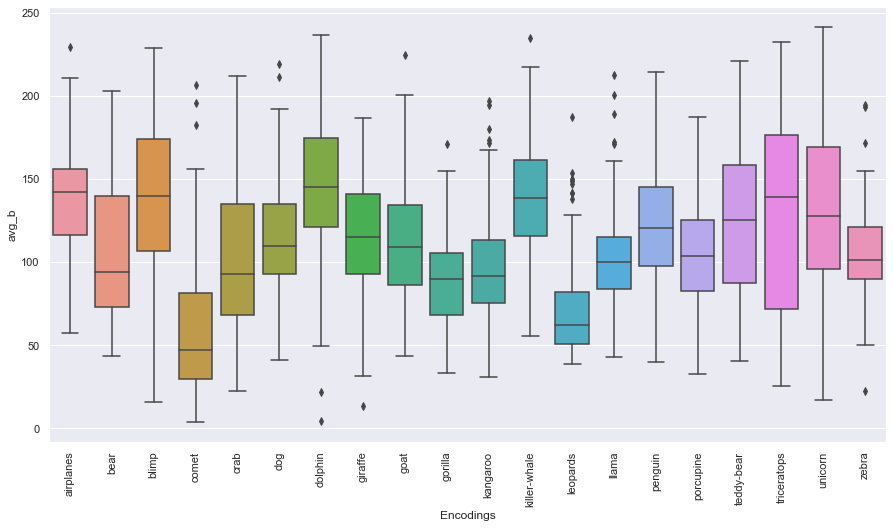

In [12]:
train_cpy["avg_b"] = learning["Pictures"].apply(ft3)
train_cpy.head()

plt.figure(figsize=(15,8))
ax = sns.boxplot(x="Encodings", y="avg_b", data=train_cpy)
ax.set_xticklabels(labels['labels'], rotation=90);

The box plot looks quite different from that of average red intensity. Specifically, airplanes, blimp, dolphin, and killer-whale stand out. It's not too much of a surprise, since all these categories are associated with water or sky, which are predominantly blue. Therefore, it could count as a useful feature.

We've examined Red and Blue in RGB. The distribution of average *green*-channel intensity is quiet similar to that of red-channel.

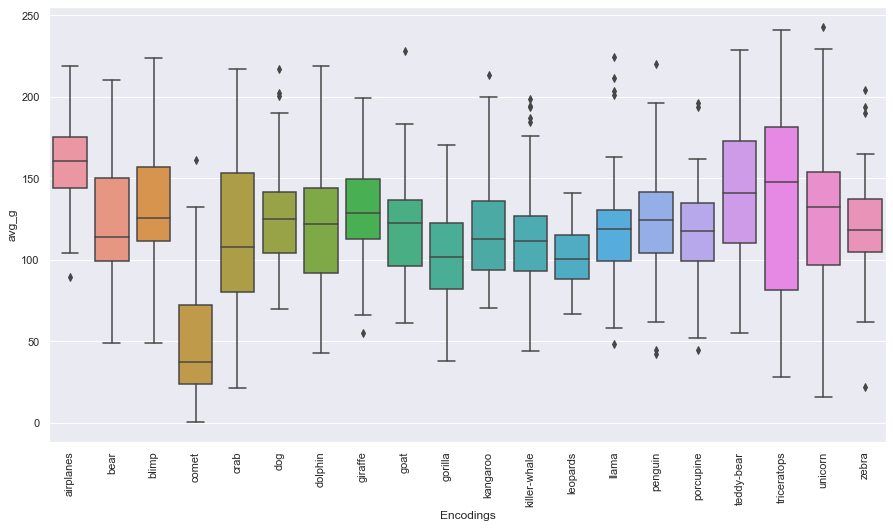

In [13]:
train_cpy["avg_g"] = learning["Pictures"].apply(ft4)
train_cpy.head()

plt.figure(figsize=(15,8))
ax = sns.boxplot(x="Encodings", y="avg_g", data=train_cpy)
ax.set_xticklabels(labels['labels'], rotation=90);

Now, let's try using Bag of Visual Words (BoVW). Warning: running this part will be super slow! Brace yourselves!

In [15]:
def get_sift_des(img):
    sift = cv2.xfeatures2d.SIFT_create()  # Use SIFT feature detector
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)    
    _, des = sift.detectAndCompute(img, None)
    return des


def build_histogram(img_des, kmeans):
    hist = np.zeros(len(kmeans.cluster_centers_))
    if img_des is None:
        return hist
    pred = kmeans.predict(img_des)
    for i in pred:
        hist[i] += 1
    return hist

First, let's get all the descriptors from the training set.

In [16]:
all_sift_des = np.vstack(learning["Pictures"].apply(get_sift_des))
print(all_sift_des.shape)

(1699217, 128)


Then, we perform K Means clustering to build histogram features.

In [79]:
# Perform K Means clustering
from sklearn.cluster import MiniBatchKMeans
sift_n_clusters = 200
kmeans = MiniBatchKMeans(n_clusters=sift_n_clusters,
                         random_state=42,
                         batch_size=1000000)
kmeans.fit(all_sift_des)

MiniBatchKMeans(batch_size=1000000, compute_labels=True, init='k-means++',
                init_size=None, max_iter=100, max_no_improvement=10,
                n_clusters=200, n_init=3, random_state=42,
                reassignment_ratio=0.01, tol=0.0, verbose=0)

In [84]:
pickle.dump(kmeans, open(f"kmeans_sift_{sift_n_clusters}.pkl", "wb"))

Now, create the Bag of Visual Words feature matrix for all iamges.

In [ ]:
hist_ls = [build_histogram(get_sift_desc(img), kmeans) for img in learning["Pictures"]]
all_hist = np.vstack(hist_ls)

In [38]:
feature_df = pd.DataFrame(all_hist)
train = pd.concat([learning, feature_df], axis=1)
train.head()

,Pictures,Encodings,0,1,2,3,4,5,6,7,...,90,91,92,93,94,95,96,97,98,99
0,"[[[255, 255, 255], [255, 255, 255], [255, 255,...",0,2.0,0.0,1.0,6.0,8.0,3.0,1.0,2.0,...,4.0,5.0,4.0,0.0,0.0,1.0,0.0,1.0,7.0,4.0
1,"[[[88, 56, 17], [95, 63, 24], [101, 69, 30], [...",0,6.0,0.0,1.0,2.0,4.0,9.0,14.0,13.0,...,13.0,6.0,2.0,0.0,0.0,3.0,0.0,7.0,3.0,9.0
2,"[[[255, 255, 255], [255, 255, 255], [255, 255,...",0,1.0,0.0,2.0,10.0,4.0,3.0,5.0,3.0,...,5.0,20.0,2.0,0.0,2.0,4.0,0.0,3.0,6.0,17.0
3,"[[[255, 255, 255], [255, 255, 255], [255, 255,...",0,3.0,1.0,0.0,7.0,2.0,1.0,0.0,1.0,...,1.0,6.0,2.0,0.0,2.0,2.0,1.0,17.0,16.0,3.0
4,"[[[255, 255, 255], [255, 255, 255], [255, 255,...",0,2.0,1.0,1.0,8.0,3.0,4.0,2.0,7.0,...,8.0,1.0,0.0,0.0,1.0,0.0,2.0,7.0,6.0,5.0


Next, let's jump back to scalar features and examine the HSV space. Starting with H (hue).

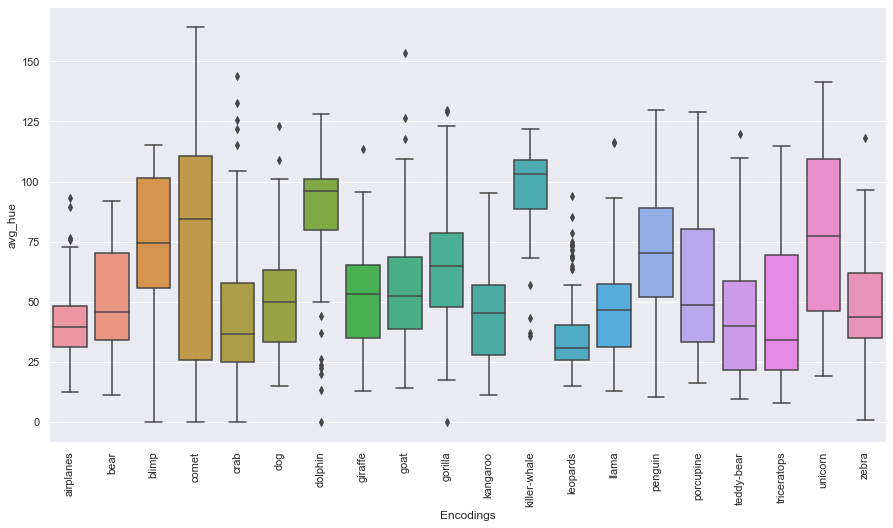

In [17]:
train_cpy["avg_hue"] = learning["Pictures"].apply(ft5)
train_cpy.head()

plt.figure(figsize=(15,8))
ax = sns.boxplot(x="Encodings", y="avg_hue", data=train_cpy)
ax.set_xticklabels(labels['labels'], rotation=90);

As expected, the hue values differ between classes. For instace, leopards, due to their color, has a hue value of about 25 - 40, which falls in the yellow spectrum. However, surprisingly, most airplanes have a yellow hue value as well. After examing the airplane images (as we already did above), it is probably because 1) sunshine is prevalent in these pictures, which is yellow, and 2) many pictures are shot on a yellow grassland. Meanwhile, dolphins have a hue value of 75-80, which falls into the green spectrum, the same as killer-whales. This is probably due to their aqua environment, which is cyan.

Second, let's examine S, which stands for saturation.

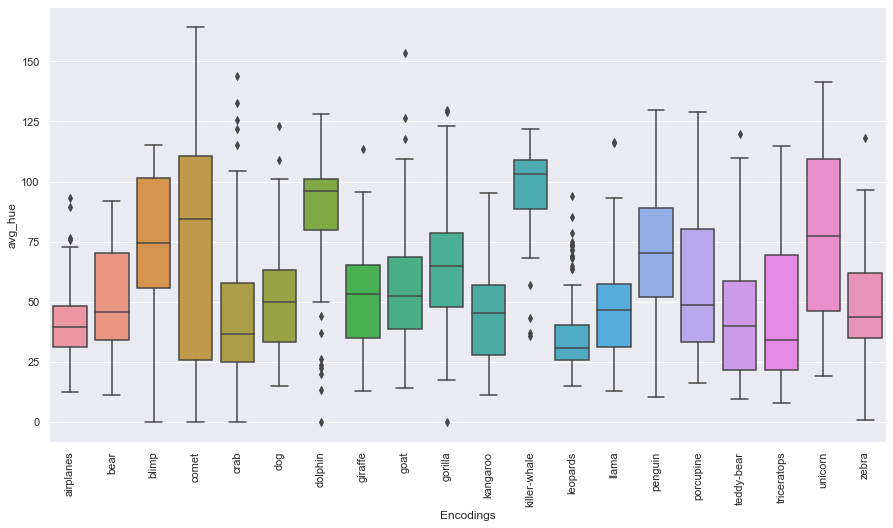

In [18]:
train_cpy["avg_sat"] = learning["Pictures"].apply(ft6)
train_cpy.head()

plt.figure(figsize=(15,8))
ax = sns.boxplot(x="Encodings", y="avg_hue", data=train_cpy)
ax.set_xticklabels(labels['labels'], rotation=90);

It seems most classes share a similar level of saturation, except for dolphin, killer-whale, and leopards. Let's see if they're really that colorful! 

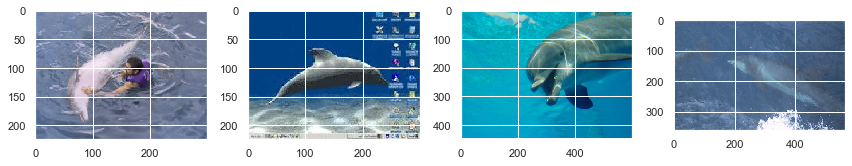

In [19]:
show_sample_images("dolphin")

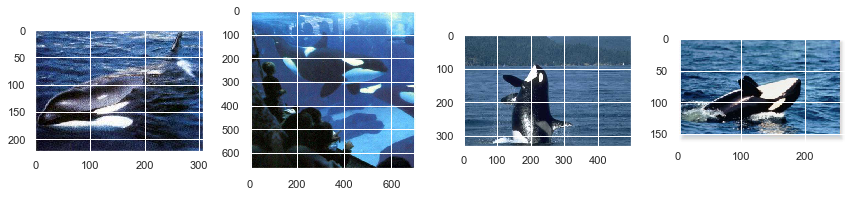

In [20]:
show_sample_images("killer-whale")

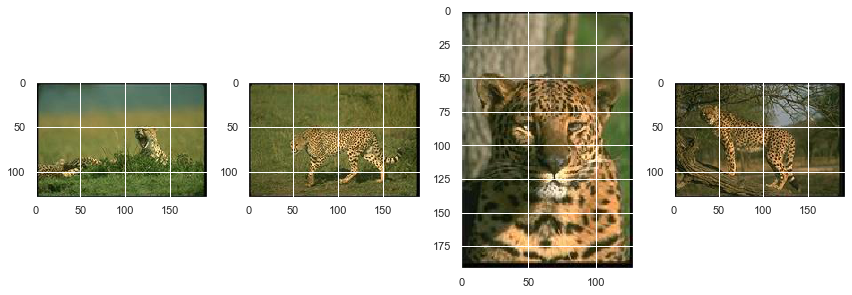

In [21]:
show_sample_images("leopards")

Indeed, dolphin and killer whale have saturated images, which is probably due to the ocean. So do the pictures of leopards. In addition, many pictures of the leopards actually look like they are taken on the same camera. This might explain why the IQR for leopards is quite narrow, with a high median value.

Lastly, let's examine the brightness value.

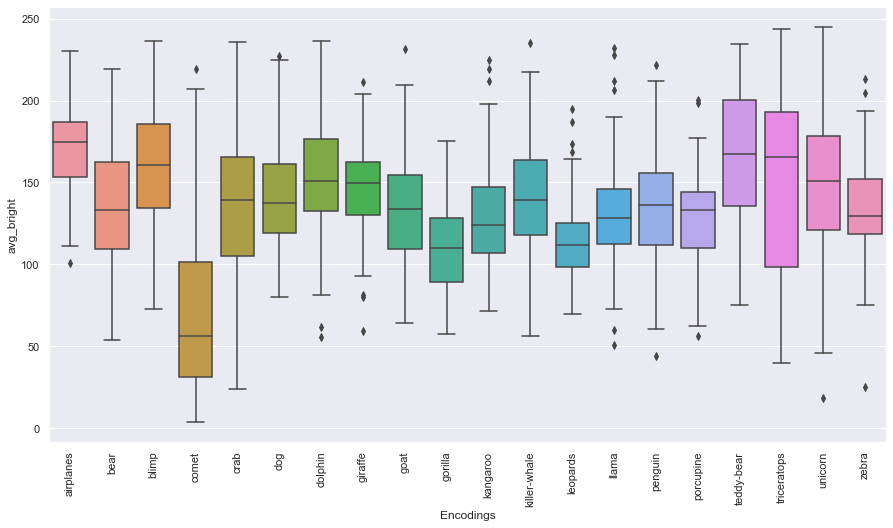

In [22]:
train_cpy["avg_bright"] = learning["Pictures"].apply(ft7)
train_cpy.head()

plt.figure(figsize=(15,8))
ax = sns.boxplot(x="Encodings", y="avg_bright", data=train_cpy)
ax.set_xticklabels(labels['labels'], rotation=90);

Commet has an average brightness lower than most classes. Let's examine some sample comet images.

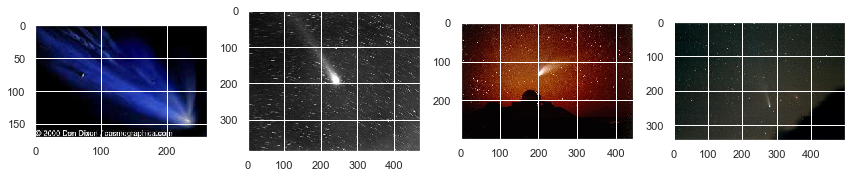

In [23]:
show_sample_images("comet")

Most pictures have a dark background, with just a comet. Therefore, it makes sense that such nighttime pictures have a low brightness value. By contrast, since most airplane pictures are taken during the day, they have a higher brightness value.

Next, let's examine another matrix feature -- Histogram of Oriented Gradients (HoG).

(900,)


/Users/Jerome/anaconda/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:75: UserWarning: Low image data range; displaying image with stretched contrast.
  warn("Low image data range; displaying image with "


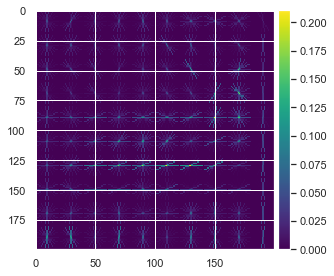

In [24]:
from skimage.feature import hog
img = learning["Pictures"].values[69]
img = resize(img, (200, 200))
fd, hog_image = hog(img, orientations=9, pixels_per_cell=(20, 20), 
                    cells_per_block=(10, 10), visualize=True, block_norm='L2')
print(fd.shape)
io.imshow(hog_image);

In [25]:
def get_hog(image):
    img = resize(image, (200, 200))
    fd, hog_image = hog(img, orientations=9, pixels_per_cell=(20, 20), 
                        cells_per_block=(10, 10), visualize=True, block_norm='L2')
    return fd

The visualized gradient image does not seem particularly helpful. Indeed, after trying it out, the prediction accuracy doesn't increase too much.

Since HOG doesn't perform particularly well, let's try something else -- ORB. First, let's generate the descriptors. (Warning: it's gonna be super slow again due to KMeans)

In [27]:
def get_orb_des(img):
    orb = cv2.ORB_create(nfeatures=1000, edgeThreshold=15, fastThreshold=10)
    kp = orb.detect(img, None)
    _, des = orb.compute(img, kp)
    return des

In [318]:
all_orb_des = np.vstack(learning["Pictures"].apply(get_orb_des))

Then, let's train a KMeans clustering algorithm with the ORB descriptors.

In [326]:
# Perform K Means clustering
from sklearn.cluster import MiniBatchKMeans

orb_n_clusters = 100
orb_kmeans = MiniBatchKMeans(n_clusters=orb_n_clusters,
                             random_state=42,
                             batch_size=300000)
orb_kmeans.fit(all_orb_des)
pickle.dump(orb_kmeans, open(f"kmeans_orb_{orb_n_clusters}.pkl", "wb"))

Lastly, let's also take a look at SURF, which should be more efficient than SIFT.

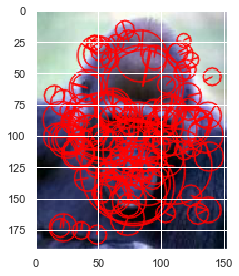

In [34]:
surf = cv2.xfeatures2d.SURF_create()
example = learning["Pictures"].values[672]
kp, des = surf.detectAndCompute(example, None)
example = cv2.drawKeypoints(example, kp, None, (255, 0, 0), 4)
io.imshow(example);

Let's stack all the SURF descriptors for all images together.

In [35]:
def get_surf_des(img):
    surf = cv2.xfeatures2d.SURF_create(hessianThreshold=28)
    kp, des = surf.detectAndCompute(img, None)
    return des

In [72]:
all_surf_des = np.vstack(learning["Pictures"].apply(get_surf_des))
print(all_surf_des.shape)

(2412720, 64)


In [70]:
surf = cv2.xfeatures2d.SURF_create(hessianThreshold=28)
kp, des = surf.detectAndCompute(learning["Pictures"].values[213], None)
print(des)

[[ 2.1633648e-03 -2.0408689e-04  2.2594796e-03  5.4380065e-04
   2.7788505e-02  3.0514605e-03  2.7788505e-02  4.8616510e-03
   4.8739031e-02  9.4555877e-03  4.8739031e-02  1.0145493e-02
   7.8383945e-03  2.9658400e-03  7.8383945e-03  2.9658400e-03
   9.5688021e-03 -1.2008115e-03  9.6576400e-03  5.8267522e-03
   2.2657856e-01 -3.2022066e-02  2.2991595e-01  5.9207231e-02
   3.9569464e-01  1.6368309e-02  3.9569464e-01  4.5525808e-02
   7.9301864e-02  2.0514905e-02  7.9301864e-02  2.0514905e-02
   6.0308278e-03  8.1594847e-04  7.5850287e-03  2.9304372e-03
   2.4185084e-01  1.0623212e-02  2.4351954e-01  5.3261675e-02
   4.4750166e-01 -8.6970609e-03  4.4750166e-01  7.6554604e-02
   9.4370037e-02  9.9008894e-03  9.4370037e-02  1.5145574e-02
   1.0506716e-03 -7.6271559e-04  1.0583758e-03  7.6946965e-04
   3.2209031e-02 -8.6522801e-03  3.2209031e-02  9.3233949e-03
   5.8971591e-02 -1.3609182e-02  5.8971591e-02  1.3609182e-02
   1.5055034e-02 -2.6553485e-03  1.5055034e-02  2.6670664e-03]]


Then, we do KMeans clustering to get the historgrams.

In [85]:
# Perform K Means clustering
surf_n_clusters = 200
surf_kmeans = MiniBatchKMeans(n_clusters=surf_n_clusters,
                             random_state=42,
                             batch_size=1000000)
surf_kmeans.fit(all_surf_des)
pickle.dump(surf_kmeans, open(f"kmeans_surf_{surf_n_clusters}.pkl", "wb"))

<h4> Sources </h4>

https://stats.stackexchange.com/questions/33046/the-most-common-extracted-features-for-image-recognition
https://en.wikipedia.org/wiki/Feature_detection_(computer_vision)
https://www.quora.com/What-common-features-of-images-are-used-in-machine-learning-training
https://docs.opencv.org/3.0-beta/doc/py_tutorials/py_feature2d/py_table_of_contents_feature2d/py_table_of_contents_feature2d.html#py-table-of-content-feature2d
https://stackoverflow.com/questions/53940258/svc-classifier-taking-too-much-time-for-training
https://www.analyticsvidhya.com/blog/2019/09/feature-engineering-images-introduction-hog-feature-descriptor/
https://gurus.pyimagesearch.com/lesson-sample-histogram-of-oriented-gradients-and-car-logo-recognition/

<h4> DataFrame Creation </h4>

In [36]:
def feature_frame(df):
    data = df.copy()
    # Convert gray to RGB
    data = all_imgs_to_rgb(data)
    print("All images converted to RGB format.")
    # Scalar features
    data["size"] = data["Pictures"].apply(ft0)
    data["avg_r"] = data["Pictures"].apply(ft1)
    data["aspect_ratio"] = data["Pictures"].apply(ft2)
    data["avg_b"] = data["Pictures"].apply(ft3)
    data["avg_g"] = data["Pictures"].apply(ft4)
    data["avg_hue"] = data["Pictures"].apply(ft5)
    data["avg_sat"] = data["Pictures"].apply(ft6)
    data["avg_bright"] = data["Pictures"].apply(ft7)
    print("Scalar features done!")
    # SIFT feature
    print("Computing SIFT features...")
    pkl_fname = f"kmeans_sift_200.pkl"
    print("Using " + pkl_fname)
    with open(pkl_fname, "rb") as f:
        kmeans = pickle.load(f)
    feature_df = ft_sift(data, kmeans)
    data = pd.concat([data, feature_df], axis=1)
    # SURF feature
    print("Computing SURF features...")
    pkl_fname = f"kmeans_surf_200.pkl"
    print("Using " + pkl_fname)
    with open(pkl_fname, "rb") as f:
        kmeans = pickle.load(f)
    feature_df = ft_surf(data, kmeans)
    data = pd.concat([data, feature_df], axis=1)
    return data

In [37]:
learning = pd.read_pickle("train.pkl")
train_with_feature = feature_frame(learning)
train_with_feature.head()

Number of gray images: 0
All images converted to RGB format.
Scalar features done!
Computing SIFT features...
Using kmeans_sift_200.pkl
Computing SURF features...
Using kmeans_surf_200.pkl


,Pictures,Encodings,size,avg_r,aspect_ratio,avg_b,avg_g,avg_hue,avg_sat,avg_bright,...,190,191,192,193,194,195,196,197,198,199
0,"[[[255, 255, 255], [255, 255, 255], [255, 255,...",0,194535,170.123787,2.381818,111.753798,147.788681,42.172087,120.420202,178.581633,...,1.0,5.0,6.0,1.0,1.0,1.0,0.0,1.0,2.0,0.0
1,"[[[88, 56, 17], [95, 63, 24], [101, 69, 30], [...",0,208278,98.426973,2.293103,67.531631,104.499870,40.144197,126.898583,110.955982,...,0.0,9.0,2.0,1.0,1.0,0.0,2.0,0.0,1.0,0.0
2,"[[[255, 255, 255], [255, 255, 255], [255, 255,...",0,201096,174.865318,2.292398,163.577814,175.592150,37.242541,50.880937,179.086287,...,0.0,2.0,10.0,0.0,2.0,0.0,0.0,0.0,1.0,0.0
3,"[[[255, 255, 255], [255, 255, 255], [255, 255,...",0,221352,210.739822,2.179348,164.805242,189.280101,23.024612,69.222569,210.805961,...,1.0,0.0,11.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,"[[[255, 255, 255], [255, 255, 255], [255, 255,...",0,166662,147.548565,2.794326,127.917054,155.967905,44.592073,89.481027,157.456385,...,1.0,5.0,5.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [38]:
train_with_feature.to_pickle("train_with_feature.pkl")

In [39]:
# Generate test data
test = pd.read_pickle("test.pkl")
test_with_feature = feature_frame(test)
test_with_feature.to_pickle("test_with_feature.pkl")

Number of gray images: 0
All images converted to RGB format.
Scalar features done!
Computing SIFT features...
Using kmeans_sift_200.pkl
Computing SURF features...
Using kmeans_surf_200.pkl
